In [1]:
import pandas as pd
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import accuracy_score
from datasets import Dataset
import numpy as np
import os

2024-09-08 05:33:20.432441: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 05:33:57.471808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the dataset
file_path = '/user/HS400/dd00830/Downloads/Dissertation/Dataset.csv' 
dataset = pd.read_csv(file_path)

# Display the first few rows to inspect the dataset
print(dataset.head())


   score                                           selftext subreddit  \
0    1.0  Tried to watch this documentary “anxious Ameri...   Anxiety   
1    1.0  i’m currently laying in bed wide awake, feelin...   Anxiety   
2    2.0  Second time trying weed. First time felt close...   Anxiety   
3    1.0  I am not posting this for me, but rather for m...   Anxiety   
4    1.0  21 year old male been dealing with anxiety eve...   Anxiety   

                                               title             Label CAT 1  
0                        Do people get over anxiety?  Drug and Alcohol   NaN  
1  does anyone else have this big fear of suddenl...  Drug and Alcohol   NaN  
2         3 hour long panic attack after trying weed  Drug and Alcohol   NaN  
3  Please leave in the comments ANYTHING that has...  Drug and Alcohol   NaN  
4                                    Alcohol induced  Drug and Alcohol   NaN  


In [3]:
# Drop rows with missing values in 'selftext' and 'Label' columns
dataset_clean = dataset.dropna(subset=['selftext', 'Label'])

# Display the cleaned dataset
print(dataset_clean.head())


   score                                           selftext subreddit  \
0    1.0  Tried to watch this documentary “anxious Ameri...   Anxiety   
1    1.0  i’m currently laying in bed wide awake, feelin...   Anxiety   
2    2.0  Second time trying weed. First time felt close...   Anxiety   
3    1.0  I am not posting this for me, but rather for m...   Anxiety   
4    1.0  21 year old male been dealing with anxiety eve...   Anxiety   

                                               title             Label CAT 1  
0                        Do people get over anxiety?  Drug and Alcohol   NaN  
1  does anyone else have this big fear of suddenl...  Drug and Alcohol   NaN  
2         3 hour long panic attack after trying weed  Drug and Alcohol   NaN  
3  Please leave in the comments ANYTHING that has...  Drug and Alcohol   NaN  
4                                    Alcohol induced  Drug and Alcohol   NaN  


In [4]:
# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = text.replace('\n', ' ')  # Replace newlines with spaces
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])  # Remove special characters
    return text

# Apply text preprocessing to 'selftext'
dataset_clean['selftext'] = dataset_clean['selftext'].apply(preprocess_text)

# Display the preprocessed text
print(dataset_clean[['selftext', 'Label']].head())


                                            selftext             Label
0  tried to watch this documentary anxious americ...  Drug and Alcohol
1  im currently laying in bed wide awake feeling ...  Drug and Alcohol
2  second time trying weed first time felt close ...  Drug and Alcohol
3  i am not posting this for me but rather for my...  Drug and Alcohol
4  21 year old male been dealing with anxiety eve...  Drug and Alcohol


/tmp/ipykernel_852032/2435479343.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_clean['selftext'] = dataset_clean['selftext'].apply(preprocess_text)


In [5]:
# Normalize labels to lowercase
dataset_clean['Label'] = dataset_clean['Label'].str.lower().str.strip()

# Map labels to integers after normalization
label_map = {label: idx for idx, label in enumerate(dataset_clean['Label'].unique())}

# Display the label mapping
print("Label mapping:", label_map)


Label mapping: {'drug and alcohol': 0, 'early life': 1, 'personality': 2, 'trauma and stress': 3}


/tmp/ipykernel_852032/3008239461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_clean['Label'] = dataset_clean['Label'].str.lower().str.strip()


In [6]:
# Initialize RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the 'selftext' data
tokenized_inputs = dataset_clean['selftext'].apply(
    lambda x: tokenizer(x, truncation=True, padding='max_length', max_length=128)
)


/user/HS400/dd00830/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
# Convert to a Hugging Face Dataset
dataset = Dataset.from_pandas(pd.DataFrame({
    'input_ids': [x['input_ids'] for x in tokenized_inputs],
    'attention_mask': [x['attention_mask'] for x in tokenized_inputs],
    'labels': dataset_clean['Label'].map(label_map).tolist()
}))

# Split the dataset into training and testing sets
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']


In [8]:
# Disable tqdm progress bars
os.environ["DISABLE_TQDM"] = "True"


In [9]:
# Initialize the data collator with padding
data_collator = DataCollatorWithPadding(tokenizer)

# Set up training arguments with logging and evaluation strategy
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="no",        # Save the model at the end of each epoch
    logging_strategy="epoch",     # Log training metrics at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Adjust as needed
    per_device_eval_batch_size=8,    # Adjust as needed
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=False,  # Save the best model during training
    metric_for_best_model="accuracy",  # Use accuracy to determine the best model
    fp16=True,  # Enable mixed precision training for memory efficiency
)

# Initialize the RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_map))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Define the compute_metrics function to include accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}


In [11]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


In [12]:
# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,1.212600,0.831615,0.568750
2,0.682400,0.722288,0.718750
3,0.503200,0.694237,0.750000
4,0.332400,0.757944,0.781250
5,0.177800,1.187632,0.731250
6,0.133500,1.264610,0.756250
7,0.061400,1.309558,0.762500
8,0.044600,1.546968,0.750000
9,0.028800,1.449072,0.743750
10,0.025200,1.486415,0.750000


TrainOutput(global_step=800, training_loss=0.3201902136206627, metrics={'train_runtime': 282.0001, 'train_samples_per_second': 22.695, 'train_steps_per_second': 2.837, 'total_flos': 420985248153600.0, 'train_loss': 0.3201902136206627, 'epoch': 10.0})

In [13]:
# Make predictions on the test dataset
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids


In [14]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=list(label_map.keys()))

# Print the classification report
print(report)


                   precision    recall  f1-score   support

 drug and alcohol       0.82      0.86      0.84        37
       early life       0.75      0.84      0.79        43
      personality       0.91      0.65      0.76        46
trauma and stress       0.55      0.65      0.59        34

         accuracy                           0.75       160
        macro avg       0.76      0.75      0.75       160
     weighted avg       0.77      0.75      0.75       160



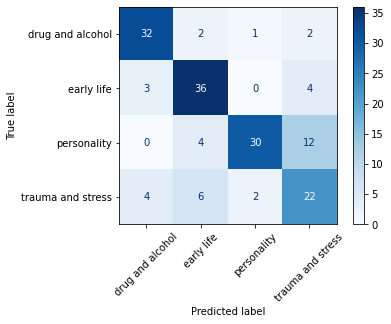

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()


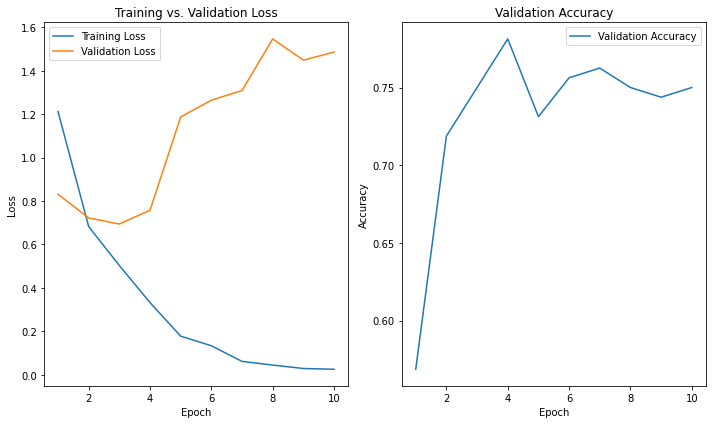

In [19]:
import matplotlib.pyplot as plt

# Initialize lists to hold the metrics
train_loss = []
eval_loss = []
train_accuracy = []
eval_accuracy = []

# Extract metrics from the trainer's log history
for log in trainer.state.log_history:
    if 'loss' in log and 'epoch' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    if 'accuracy' in log and 'epoch' in log:
        train_accuracy.append(log['accuracy'])
    if 'eval_accuracy' in log:
        eval_accuracy.append(log['eval_accuracy'])

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create subplots to plot metrics
plt.figure(figsize=(10, 6))

# Plot training and evaluation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plot training and evaluation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


## HYPER PARAMETER TUNING:-

In [7]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2024-09-08 04:41:53.974583: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 04:41:54.005532: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
import optuna
import tensorflow as tf
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming `dataset_clean` has 'selftext' and 'Label'
texts = dataset_clean['selftext'].tolist()
labels = dataset_clean['Label'].tolist()

# Convert labels to numeric values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

def objective(trial):
    # Define the hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 2e-5, log=True)
    batch_size = trial.suggest_categorical('batch_size', [4, 8])
    num_epochs = trial.suggest_int('num_epochs', 1, 3)
    max_length = trial.suggest_int('max_length', 128, 256)

    # Load the tokenizer and model
    tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
    model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_map))

    # Tokenize the data
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)

    # Convert to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        train_labels
    )).shuffle(len(train_texts)).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        val_labels
    )).batch(batch_size)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    # Train the model
    model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)
    

    # Evaluate the model
    eval_loss, eval_accuracy = model.evaluate(val_dataset)

    # We want to minimize the loss
    return eval_loss 


# Run the hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print("Best hyperparameters found: ", study.best_params)


[I 2024-09-08 05:36:15,618] A new study created in memory with name: no-name-53ad43e8-7b02-4586-946e-c08d2e19b618
/user/HS400/dd00830/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-09-08 05:36:16.580460: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 05:36:16.736984: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at http

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
160/160 [==============================] - 278s 1s/step - loss: 1.1937 - sparse_categorical_accuracy: 0.4250 - val_loss: 0.8848 - val_sparse_categorical_accuracy: 0.6750
Epoch 2/3
160/160 [==============================] - 233s 1s/step - loss: 0.7425 - sparse_categorical_accuracy: 0.7141 - val_loss: 0.8621 - val_sparse_categorical_accuracy: 0.6687
Epoch 3/3
40/40 [==============================] - 11s 269ms/step - loss: 0.8724 - sparse_categorical_accuracy: 0.7000


[I 2024-09-08 05:49:24,441] Trial 0 finished with value: 0.8723586201667786 and parameters: {'learning_rate': 1.6496991171384256e-05, 'batch_size': 4, 'num_epochs': 3, 'max_length': 131}. Best is trial 0 with value: 0.8723586201667786.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch 

Epoch 1/3
160/160 [==============================] - 268s 2s/step - loss: 1.1156 - sparse_categorical_accuracy: 0.4906 - val_loss: 0.8805 - val_sparse_categorical_accuracy: 0.6687
Epoch 2/3
160/160 [==============================] - 236s 1s/step - loss: 0.6324 - sparse_categorical_accuracy: 0.7750 - val_loss: 0.7326 - val_sparse_categorical_accuracy: 0.7063
Epoch 3/3
40/40 [==============================] - 11s 276ms/step - loss: 0.7371 - sparse_categorical_accuracy: 0.7000


[I 2024-09-08 06:01:57,632] Trial 1 finished with value: 0.7370930314064026 and parameters: {'learning_rate': 1.0352221430890854e-05, 'batch_size': 4, 'num_epochs': 3, 'max_length': 133}. Best is trial 1 with value: 0.7370930314064026.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch 

Epoch 1/2
160/160 [==============================] - 291s 2s/step - loss: 1.1569 - sparse_categorical_accuracy: 0.4578 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.7563
Epoch 2/2
40/40 [==============================] - 13s 320ms/step - loss: 0.7217 - sparse_categorical_accuracy: 0.7625


[I 2024-09-08 06:11:22,341] Trial 2 finished with value: 0.7216511964797974 and parameters: {'learning_rate': 1.4049512657188667e-05, 'batch_size': 4, 'num_epochs': 2, 'max_length': 154}. Best is trial 2 with value: 0.7216511964797974.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch 

Epoch 1/2
80/80 [==============================] - 277s 3s/step - loss: 1.3429 - sparse_categorical_accuracy: 0.3375 - val_loss: 0.9116 - val_sparse_categorical_accuracy: 0.6562
Epoch 2/2
20/20 [==============================] - 15s 757ms/step - loss: 0.7460 - sparse_categorical_accuracy: 0.7125


[I 2024-09-08 06:20:21,293] Trial 3 finished with value: 0.7460393309593201 and parameters: {'learning_rate': 1.5893846468672843e-05, 'batch_size': 8, 'num_epochs': 2, 'max_length': 179}. Best is trial 2 with value: 0.7216511964797974.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch 

Epoch 1/2
80/80 [==============================] - 290s 3s/step - loss: 1.3266 - sparse_categorical_accuracy: 0.3453 - val_loss: 0.9169 - val_sparse_categorical_accuracy: 0.6500
Epoch 2/2
20/20 [==============================] - 16s 798ms/step - loss: 0.6362 - sparse_categorical_accuracy: 0.7437


[I 2024-09-08 06:29:44,956] Trial 4 finished with value: 0.6362490057945251 and parameters: {'learning_rate': 1.5590236997640684e-05, 'batch_size': 8, 'num_epochs': 2, 'max_length': 189}. Best is trial 4 with value: 0.6362490057945251.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch 

Epoch 1/3
160/160 [==============================] - 371s 2s/step - loss: 1.1460 - sparse_categorical_accuracy: 0.4594 - val_loss: 0.9562 - val_sparse_categorical_accuracy: 0.6187
Epoch 2/3
160/160 [==============================] - 337s 2s/step - loss: 0.6380 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.6800 - val_sparse_categorical_accuracy: 0.7188
Epoch 3/3
40/40 [==============================] - 19s 468ms/step - loss: 0.6886 - sparse_categorical_accuracy: 0.7688


[I 2024-09-08 06:47:32,458] Trial 5 finished with value: 0.688551127910614 and parameters: {'learning_rate': 1.7540089686552948e-05, 'batch_size': 4, 'num_epochs': 3, 'max_length': 219}. Best is trial 4 with value: 0.6362490057945251.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch m

40/40 [==============================] - 13s 314ms/step - loss: 0.8373 - sparse_categorical_accuracy: 0.6562


[I 2024-09-08 06:52:37,662] Trial 6 finished with value: 0.8373271822929382 and parameters: {'learning_rate': 1.2098818688916646e-05, 'batch_size': 4, 'num_epochs': 1, 'max_length': 151}. Best is trial 4 with value: 0.6362490057945251.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch 

Epoch 1/3
80/80 [==============================] - 214s 2s/step - loss: 1.2768 - sparse_categorical_accuracy: 0.3844 - val_loss: 0.9650 - val_sparse_categorical_accuracy: 0.5875
Epoch 2/3
80/80 [==============================] - 181s 2s/step - loss: 0.7299 - sparse_categorical_accuracy: 0.7234 - val_loss: 0.7078 - val_sparse_categorical_accuracy: 0.7312
Epoch 3/3
20/20 [==============================] - 10s 519ms/step - loss: 0.8323 - sparse_categorical_accuracy: 0.6875


[I 2024-09-08 07:02:27,401] Trial 7 finished with value: 0.8322893977165222 and parameters: {'learning_rate': 1.3896835938347669e-05, 'batch_size': 8, 'num_epochs': 3, 'max_length': 128}. Best is trial 4 with value: 0.6362490057945251.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch 

Epoch 1/3
80/80 [==============================] - 358s 4s/step - loss: 1.3130 - sparse_categorical_accuracy: 0.3344 - val_loss: 1.0152 - val_sparse_categorical_accuracy: 0.6125
Epoch 2/3
80/80 [==============================] - 325s 4s/step - loss: 0.6729 - sparse_categorical_accuracy: 0.7484 - val_loss: 0.6977 - val_sparse_categorical_accuracy: 0.6938
Epoch 3/3
20/20 [==============================] - 21s 1s/step - loss: 0.6363 - sparse_categorical_accuracy: 0.7750


[I 2024-09-08 07:19:39,131] Trial 8 finished with value: 0.6362766623497009 and parameters: {'learning_rate': 1.347574455797612e-05, 'batch_size': 8, 'num_epochs': 3, 'max_length': 242}. Best is trial 4 with value: 0.6362490057945251.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch m

40/40 [==============================] - 14s 360ms/step - loss: 0.8708 - sparse_categorical_accuracy: 0.6875


[I 2024-09-08 07:25:08,636] Trial 9 finished with value: 0.8708280324935913 and parameters: {'learning_rate': 1.9953442911899407e-05, 'batch_size': 4, 'num_epochs': 1, 'max_length': 174}. Best is trial 4 with value: 0.6362490057945251.


Best hyperparameters found:  {'learning_rate': 1.5590236997640684e-05, 'batch_size': 8, 'num_epochs': 2, 'max_length': 189}


## BEST HYPER PARAMETER

In [8]:
# Retrieve best hyperparameters
best_params = study.best_params

# Retrain the model on the full dataset using the best hyperparameters
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_map))

# Tokenize the full dataset
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=best_params['max_length'])
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=best_params['max_length'])

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(len(train_texts)).batch(best_params['batch_size'])

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(best_params['batch_size'])

# Compile the model with the best learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Train with potentially more epochs
model.fit(train_dataset, validation_data=val_dataset, epochs=best_params['num_epochs'])

# Evaluate the model
eval_loss, eval_accuracy = model.evaluate(val_dataset)
print(f"Evaluation Loss: {eval_loss}, Evaluation Accuracy: {eval_accuracy}")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/2
80/80 [==============================] - 288s 3s/step - loss: 1.3172 - sparse_categorical_accuracy: 0.3453 - val_loss: 0.9365 - val_sparse_categorical_accuracy: 0.6812
Epoch 2/2
20/20 [==============================] - 16s 791ms/step - loss: 0.6522 - sparse_categorical_accuracy: 0.7312
Evaluation Loss: 0.6522265672683716, Evaluation Accuracy: 0.731249988079071


20/20 [==============================] - 21s 792ms/step
                   precision    recall  f1-score   support

 drug and alcohol       0.86      0.84      0.85        37
       early life       0.81      0.91      0.86        43
      personality       0.66      0.60      0.63        35
trauma and stress       0.59      0.58      0.58        45

         accuracy                           0.73       160
        macro avg       0.73      0.73      0.73       160
     weighted avg       0.73      0.73      0.73       160



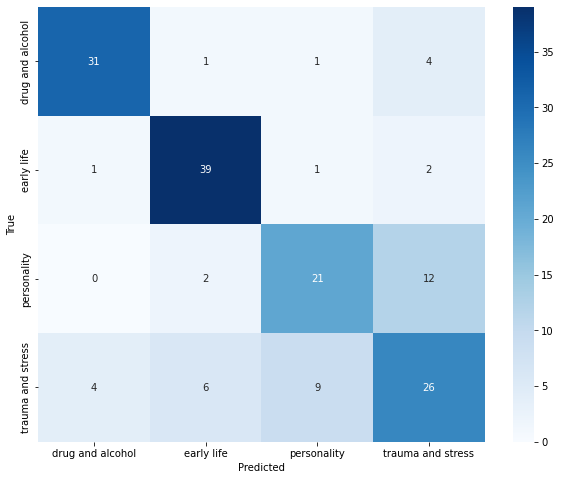

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
val_predictions = model.predict(val_dataset).logits
val_predictions = tf.argmax(val_predictions, axis=1).numpy()

# Generate the classification report
print(classification_report(val_labels, val_predictions, target_names=list(label_map.keys())))

# Generate the confusion matrix
cm = confusion_matrix(val_labels, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
